In [ ]:
pip install llama-index-core llama-index-readers-file llama-index-llms-ollama llama-index-embeddings-huggingface

In [ ]:
pip install llama_index

In [ ]:
%pip install llama-index-embeddings-ollama

In [ ]:
pip install spacy

In [ ]:
!pip install llama-index-llms-langchain

In [ ]:
!pip install llama-index-embeddings-langchain

In [9]:
import os
#imposto la chiavi per i servizi che utilizzerò
os.environ["GROQ_API_KEY"] = "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"
os.environ['LANGCHAIN_API_KEY'] = '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'
os.environ["AZURE_OPENAI_API_KEY"] = "21a4eae201494ec581d92fbeb45891b3" #Mbesi Open 9d7cdcf0ed72472dbf75f7e02a25d506 - # Mbesi est 21a4eae201494ec581d92fbeb45891b3

In [10]:
azure_configs = {
    "base_url": "https://mbesiest.openai.azure.com/", # Mbesi open https://mbesiopen.openai.azure.com/ - Mbesi est https://mbesiest.openai.azure.com/
    "model_deployment": "gpt-4o-mini",
    "model_name": "gpt-4o-mini",
    "embedding_deployment": "text-embedding-ada-002",
    "embedding_name": "text-embedding-ada-002",  # most likely  text-embedding-ada-002
}

In [11]:
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings
from ragas import evaluate

azure_model_GPT3 = AzureChatOpenAI(
    openai_api_version="2024-06-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment="gpt-35-turbo",
    model="gpt-35-turbo",
    validate_base_url=False,
)
azure_model_GPT4OMINI = AzureChatOpenAI(
    openai_api_version="2024-06-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["model_deployment"],
    model=azure_configs["model_name"],
    validate_base_url=False,
)

# init the embeddings for answer_relevancy, answer_correctness and answer_similarity
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version="2024-02-01",
    azure_endpoint=azure_configs["base_url"],
    azure_deployment=azure_configs["embedding_deployment"],
    model=azure_configs["embedding_name"],
)

In [ ]:
!pip install llama-index-llms-azure-openai

In [44]:
from llama_index.llms.azure_openai import AzureOpenAI

aoai_api_key = "21a4eae201494ec581d92fbeb45891b3"
aoai_endpoint = "https://mbesiest.openai.azure.com/"
aoai_api_version = "2024-06-01"

llmGPT4O = AzureOpenAI(
    engine="gpt-4o-mini",
    model="gpt-4o-mini",
    api_key=aoai_api_key,
    azure_endpoint=aoai_endpoint,
    api_version=aoai_api_version,
)

In [12]:
from llama_index.core import SimpleDirectoryReader

In [13]:
import nest_asyncio
import openai
import time

nest_asyncio.apply()

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext,
)
from llama_index.core.evaluation import ( DatasetGenerator, FaithfulnessEvaluator,  RelevancyEvaluator)
from llama_index.llms.openai import OpenAI



In [14]:
from llama_index.readers.file import (
    PandasCSVReader,
    CSVReader
)
# CSV Reader Llamaindex
parser = CSVReader()
file_extractor = {".csv": parser}  # Add other CSV formats as needed
documents = SimpleDirectoryReader(
    "./documenti", file_extractor=file_extractor
).load_data()

In [ ]:
documents

In [40]:
from llama_index.llms.ollama import Ollama

llama = Ollama(model="llama3.1", request_timeout=120.0)

In [13]:
from llama_index.embeddings.ollama import OllamaEmbedding

emb_ollama = OllamaEmbedding(model_name="nomic-embed-text")

### VECCHIO METODO DELLA LIBRERIA

In [ ]:
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator

# Per valutare le dimensioni di ciascun chunk, genereremo prima un insieme di 40 domande dalle prime 20 pagine..
eval_documents = documents[:20]
data_generator = DatasetGenerator.from_documents(documents, llm=azure_model_GPT4OMINI)
eval_questions = data_generator.generate_questions_from_nodes(num = 20)


# Define Faithfulness and Relevancy Evaluators which are based on GPT-4
faithfulness_gpt4 = FaithfulnessEvaluator(llm=llmGPT4O)
relevancy_gpt4 = RelevancyEvaluator(llm=llmGPT4O)


In [28]:
eval_questions

['Sure! Here are 10 questions based on the provided context:',
 '**True or False:** A brief episode of affanno after a walk always indicates a serious health issue.',
 '**Multiple Choice:** What should you do if you experience persisting affanno after physical activity?',
 '- A) Ignore it',
 '- B) Consult a doctor',
 '- C) Increase exercise intensity',
 '- D) Change your diet',
 '**Short Answer:** What factors should be considered when evaluating a brief episode of affanno after a walk?',
 "**Fill in the Blank:** If you experience affanno that is accompanied by ________ or ________, it's important to seek medical attention immediately.",
 '**Essay:** Discuss the importance of monitoring symptoms like affanno after physical activity and the potential implications for cardiovascular health.',
 '**True or False:** It is normal to experience a slight affanno after a walk, especially if one is not accustomed to regular exercise.',
 '**Multiple Choice:** Which of the following symptoms shoul

 ### NUOVO METODO DELLA LIBRERIA

In [ ]:
from llama_index.core.llama_dataset.generator import RagDatasetGenerator , LabelledRagDataset
from llama_index.core import Settings
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator

# Supponendo che `documents` e `gpt4` siano già definiti

# Utilizzare le prime 20 pagine per la valutazione
eval_documents = documents[:20]

# Generare un set di 40 domande dalle prime 20 pagine utilizzando il nuovo RagDatasetGenerator
#data_generator = RagDatasetGenerator.from_documents(documents, llm=llama)
#eval_questions = data_generator.generate_questions_from_nodes(num=40)

dataset_generator = RagDatasetGenerator.from_documents(
    eval_documents,
    llm=llmGPT4O,
    num_questions_per_chunk=2,  # set the number of questions per nodes
    show_progress=True,
)

rag_dataset = dataset_generator.generate_dataset_from_nodes()

# Definire gli Evaluatori di Accuratezza e Rilevanza basati su GPT-4
faithfulness_gpt4 = FaithfulnessEvaluator(llm=llmGPT4O)
relevancy_gpt4 = RelevancyEvaluator(llm=llmGPT4O)


In [76]:
import pickle
# Salva resultsDict su un file per poter riaccedere successivamente
with open('rag_dataset.pkl', 'wb') as f: #Cambianome per salvare più modelli 
    pickle.dump(rag_dataset, f)

In [ ]:
# Se lo voglio caricare
with open('rag_dataset.pkl', 'rb') as f:
    rag_dataset = pickle.load(f)

In [ ]:
rag_dataset

In [59]:
rag_dataset.to_pandas()

,query,reference_contexts,reference_answer,reference_answer_by,query_by
0,Quali fattori dovresti considerare se hai sper...,[﻿DOMANDE;RISPOSTE\nHo avuto un breve affanno ...,Se hai sperimentato un breve episodio di affan...,ai (gpt-4o-mini),ai (gpt-4o-mini)
1,In quali circostanze è consigliabile consultar...,[﻿DOMANDE;RISPOSTE\nHo avuto un breve affanno ...,È consigliabile consultare un medico dopo aver...,ai (gpt-4o-mini),ai (gpt-4o-mini)
2,Quali sono i principali fattori che possono co...,[Devo preoccuparmi se ho avuto un leggero affa...,I principali fattori che possono contribuire a...,ai (gpt-4o-mini),ai (gpt-4o-mini)
3,È normale sentirsi affaticati dopo una cammina...,[Devo preoccuparmi se ho avuto un leggero affa...,"Sì, è normale sentirsi affaticati dopo una cam...",ai (gpt-4o-mini),ai (gpt-4o-mini)
4,Quali sono i principali fattori che possono co...,[Quali sono i fattori che contribuiscono all'i...,I principali fattori che possono contribuire a...,ai (gpt-4o-mini),ai (gpt-4o-mini)
...,...,...,...,...,...
335,In che modo l'ascolto di musica rilassante può...,[;Le tecniche di respirazione profonda e medit...,L'ascolto di musica rilassante può influenzare...,ai (gpt-4o-mini),ai (gpt-4o-mini)
336,Quali sono alcuni dei benefici dell'ascolto di...,"[;La musica classica, il jazz, e certe forme...",L'ascolto di musica rilassante offre diversi b...,ai (gpt-4o-mini),ai (gpt-4o-mini)
337,In quali situazioni è normale osservare un aum...,"[;La musica classica, il jazz, e certe forme...",È normale osservare un aumento della frequenza...,ai (gpt-4o-mini),ai (gpt-4o-mini)
338,In quali circostanze un battito cardiaco accel...,[Una frequenza cardiaca elevata indica sempre ...,Un battito cardiaco accelerato è considerato n...,ai (gpt-4o-mini),ai (gpt-4o-mini)


In [80]:
Ragdf= rag_dataset.to_pandas()
Ragdf.to_csv('QUERYGENERATEGPT4CHUNK.csv', index=False )

In [ ]:
# Supponendo che il dataset sia memorizzato nella variabile rag_dataset
domande = [example.query for example in rag_dataset.examples]

# Stampa le domande estratte
for domanda in domande:
    print(domanda)


In [ ]:
# Estrai solo le prime 10 domande dal dataset
prime_10_domande = [example.query for example in rag_dataset.examples[:10]]

# Stampa le prime 10 domande
for domanda in prime_10_domande:
    print(domanda)


CHUNK OVERLAP = A 10 PERCHE'
- Bilanciamento tra continuità e ridondanza: Un overlap troppo piccolo potrebbe causare perdita di contesto tra i chunk. Un overlap troppo grande aumenterebbe eccessivamente la ridondanza e il costo computazionale.


- Mantenimento del contesto: Dividendo per 10, si ottiene un overlap che di solito include abbastanza testo per mantenere il contesto tra i chunk adiacenti.


- Efficienza computazionale: Questo rapporto offre un buon compromesso tra la qualità dei risultati e l'efficienza computazionale.


- Adattabilità a diverse lunghezze di chunk: Questa regola si adatta bene a varie dimensioni di chunk, da quelli più piccoli a quelli più grandi.

### VALUTAZIONE PER OGNI CHUNK CON NUOVA LIBRERIA

In [ ]:
import time
import pandas as pd
from IPython.display import display

# Define the function to calculate average response time, average faithfulness, and average relevancy metrics
def evaluate_response_time_and_accuracy(chunk_size):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, llm=azure_model_GPT4OMINI, embed_model=azure_embeddings, chunk_size=chunk_size, chunk_overlap=chunk_size // 10
    )

    query_engine = vector_index.as_query_engine()
    num_questions = len(prime_10_domande)

    for question in prime_10_domande:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time

        faithfulness_result = faithfulness_gpt4.evaluate_response(
            response=response_vector
        ).passing

        relevancy_result = relevancy_gpt4.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy

# Prepare a list to store the results for each chunk size
results = []

# Iterate over different chunk sizes to evaluate the metrics
for chunk_size in [128, 256, 512, 1024, 2048]:
    avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.2f}s, Average Faithfulness: {avg_faithfulness:.2f}, Average Relevancy: {avg_relevancy:.2f}")
    
    # Append the results to the list
    results.append({
        "Chunk Size": chunk_size,
        "Average Response Time (s)": avg_time,
        "Average Faithfulness": avg_faithfulness,
        "Average Relevancy": avg_relevancy
    })

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
display(df)


In [ ]:
#creo il csv 
df.to_csv('RisultatiChunkGPT4O.csv', index=False )
df

### VALUTAZIONE PER OGNI CHUNK CON VECCHIA LIBRERIA

In [51]:
import time
import pandas as pd
from IPython.display import display

# Define the function to calculate average response time, average faithfulness, and average relevancy metrics
def evaluate_response_time_and_accuracy(chunk_size):
    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, llm=azure_model_GPT4OMINI, embed_model=azure_embeddings, chunk_size=chunk_size, chunk_overlap=chunk_size // 10
    )

    query_engine = vector_index.as_query_engine()
    num_questions = len(eval_questions)

    for question in eval_questions:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time

        faithfulness_result = faithfulness_gpt4.evaluate_response(
            response=response_vector
        ).passing

        relevancy_result = relevancy_gpt4.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy

# Prepare a list to store the results for each chunk size
results = []

# Iterate over different chunk sizes to evaluate the metrics
for chunk_size in [128, 256, 512, 1024, 2048]:
    avg_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_time:.2f}s, Average Faithfulness: {avg_faithfulness:.2f}, Average Relevancy: {avg_relevancy:.2f}")
    
    # Append the results to the list
    results.append({
        "Chunk Size": chunk_size,
        "Average Response Time (s)": avg_time,
        "Average Faithfulness": avg_faithfulness,
        "Average Relevancy": avg_relevancy
    })

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
display(df)


Chunk size 128 - Average Response time: 1.50s, Average Faithfulness: 0.95, Average Relevancy: 0.85
Chunk size 256 - Average Response time: 1.12s, Average Faithfulness: 0.95, Average Relevancy: 0.75
Chunk size 512 - Average Response time: 1.61s, Average Faithfulness: 1.00, Average Relevancy: 0.85
Chunk size 1024 - Average Response time: 1.40s, Average Faithfulness: 0.95, Average Relevancy: 0.85
Chunk size 2048 - Average Response time: 1.26s, Average Faithfulness: 0.90, Average Relevancy: 0.75


,Chunk Size,Average Response Time (s),Average Faithfulness,Average Relevancy
0,128,1.502399,0.95,0.85
1,256,1.121754,0.95,0.75
2,512,1.608827,1.00,0.85
3,1024,1.397066,0.95,0.85
4,2048,1.261117,0.90,0.75


### GRAFICO A LINEE

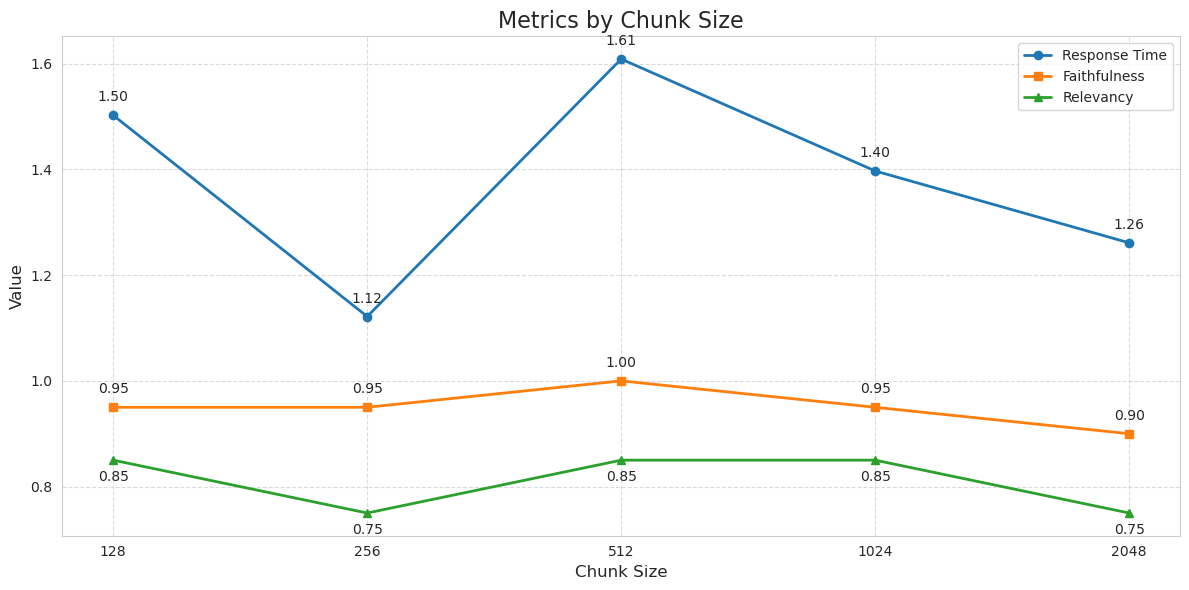

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Dati
data = {
    'Chunk Size': [128, 256, 512, 1024, 2048],
    'Average Response Time (s)': [1.502399, 1.121754, 1.608827, 1.397066, 1.261117],
    'Average Faithfulness': [0.95, 0.95, 1.00, 0.95, 0.90],
    'Average Relevancy': [0.85, 0.75, 0.85, 0.85, 0.75]
}

df = pd.DataFrame(data)

# Creazione del grafico
plt.figure(figsize=(12, 6))

# Linee
plt.plot(df['Chunk Size'], df['Average Response Time (s)'], marker='o', linewidth=2, label='Response Time')
plt.plot(df['Chunk Size'], df['Average Faithfulness'], marker='s', linewidth=2, label='Faithfulness')
plt.plot(df['Chunk Size'], df['Average Relevancy'], marker='^', linewidth=2, label='Relevancy')

# Personalizzazione del grafico
plt.title('Metrics by Chunk Size', fontsize=16)
plt.xlabel('Chunk Size', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Personalizzazione degli assi
plt.xscale('log', base=2)  # Scala logaritmica per l'asse x
plt.xticks(df['Chunk Size'], df['Chunk Size'], rotation=0)

# Aggiunta di etichette ai punti
for i, row in df.iterrows():
    plt.annotate(f"{row['Average Response Time (s)']:.2f}", 
                 (row['Chunk Size'], row['Average Response Time (s)']),
                 textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f"{row['Average Faithfulness']:.2f}", 
                 (row['Chunk Size'], row['Average Faithfulness']),
                 textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f"{row['Average Relevancy']:.2f}", 
                 (row['Chunk Size'], row['Average Relevancy']),
                 textcoords="offset points", xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()

### GRAFICO A BARRE

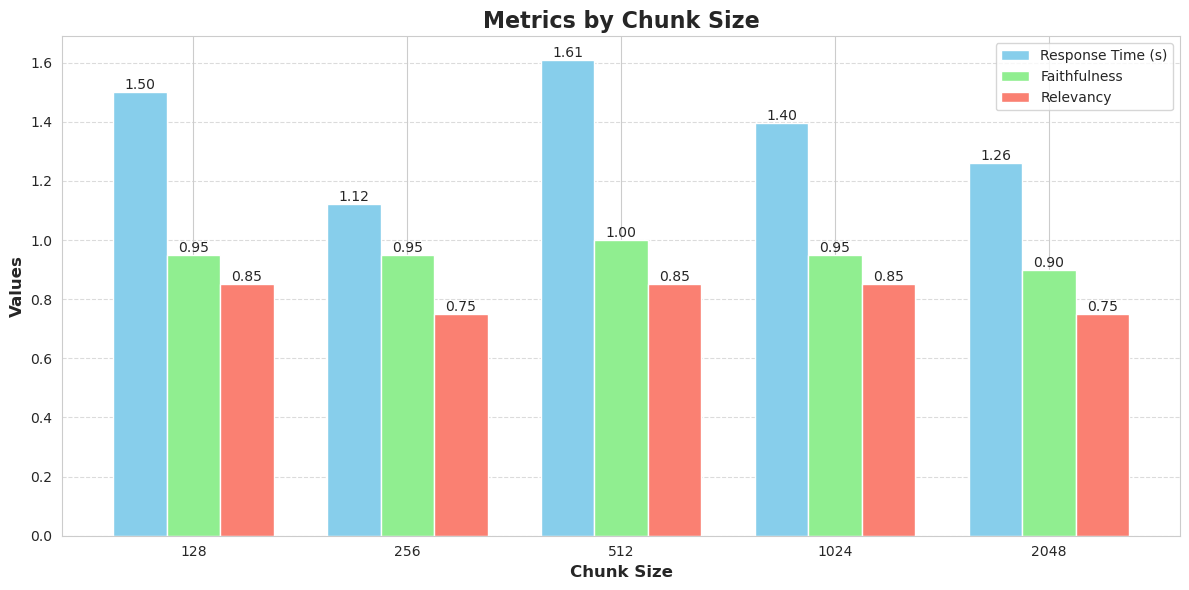

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Dati
chunk_sizes = [128, 256, 512, 1024, 2048]
response_times = [1.502399, 1.121754, 1.608827, 1.397066, 1.261117]
faithfulness = [0.95, 0.95, 1.00, 0.95, 0.90]
relevancy = [0.85, 0.75, 0.85, 0.85, 0.75]

# Impostazione del grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Larghezza delle barre
bar_width = 0.25

# Posizioni delle barre
r1 = np.arange(len(chunk_sizes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creazione delle barre
plt.bar(r1, response_times, color='skyblue', width=bar_width, label='Response Time (s)')
plt.bar(r2, faithfulness, color='lightgreen', width=bar_width, label='Faithfulness')
plt.bar(r3, relevancy, color='salmon', width=bar_width, label='Relevancy')

# Personalizzazione del grafico
plt.xlabel('Chunk Size', fontweight='bold', fontsize=12)
plt.ylabel('Values', fontweight='bold', fontsize=12)
plt.title('Metrics by Chunk Size', fontweight='bold', fontsize=16)
plt.xticks([r + bar_width for r in range(len(chunk_sizes))], chunk_sizes)

# Aggiunta di etichette sopra le barre
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

add_labels(ax.patches[::3])  # Response Time
add_labels(ax.patches[1::3])  # Faithfulness
add_labels(ax.patches[2::3])  # Relevancy

# Legenda
plt.legend()

# Griglia
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Analisi dei Dati

### Dimensioni dei Chunk
- **Dimensioni più piccole (128, 256)**: Offrono tempi di risposta variabili, con 256 che fornisce il tempo più rapido (1.121754s). La fedeltà è costante a 0.95, ma la pertinenza è inferiore (0.85 e 0.75 rispettivamente) rispetto ad alcune dimensioni maggiori.

- **Dimensioni medie (512)**: Mostrano il tempo di risposta più lungo (1.608827s), ma compensano con la massima fedeltà (1.00) e un'alta pertinenza (0.85). 

- **Dimensioni più grandi (1024, 2048)**: Presentano tempi di risposta intermedi. La dimensione 1024 mantiene alta fedeltà (0.95) e pertinenza (0.85), mentre 2048 mostra un leggero calo in entrambe (0.90 per fedeltà, 0.75 per pertinenza).

### Raccomandazione
**Dimensione del Chunk di 512**: Questa dimensione sembra offrire il miglior equilibrio complessivo. Nonostante il tempo di risposta più lungo, fornisce la massima fedeltà e un'alta pertinenza, che potrebbero essere cruciali per la qualità delle risposte.

**Dimensione del Chunk di 1024**: Potrebbe essere una valida alternativa se si cerca un compromesso tra tempo di risposta e qualità. Mantiene alti livelli di fedeltà e pertinenza con un tempo di risposta più moderato rispetto a 512.